In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Outline
To build a neural net from scratch, we need to go over each block and code those individually. At the end we can combine all of these to create an $L$-layer NN.

So, the steps we need to take are:
<ul>
    <li>Parameter Intialization: We need to initialize parameters $W$ and $b$</li>
    <li>Compute a forward propagation pass: This involves computing the linear pass - $Z^{[l]}=W^{[l]}A^{[l-1]}+b^{[l]}$ - and the activation $A^{[l]}=g(Z^{[l]})$ for both Sigmoid and ReLU activations</li>
    <li>Compute the loss</li>
    <li>Implement a back propagation pass</li>
    <li>Update the parameters: Here I'll code in mini Batch Gradient Descent (Which will cover both Stochastic Gradient Descent as well as Batch Gradient Descent), Momentum, RMSProp, and the king of them all, Adam</li>
</ul>

## Activation Functions
To add non-linearity to the model, activation functions are used. I'll define them now.
I'll be using ReLU (rectified linear unit) and sigmoid in an example, but I'll also define tanh and leaky ReLU. 

In [10]:
def relu(Z):
    """
    Arguments:
    Z -- output of linear function Z = W*A+b
    
    Returns:
    ret -- ReLU(Z)
    Z -- input for use in backprop
    
    """
    return np.maximum(0,Z), Z

def sigmoid(Z):
    """
    Arguments:
    Z -- output of linear function Z = W*A+b
    
    Returns:
    ret -- sigmoid(Z)
    Z -- input for use in backprop
    
    """
    return 1./(1.+np.exp(-Z)), Z

def tanh(Z):
    """
    Arguments:
    Z -- output of linear function Z = W*A+b
    
    Returns:
    ret -- tanh(Z)
    Z -- input for use in backprop
    
    """
    return np.tanh(Z), Z

def leaky_relu(Z):
    """
    Arguments:
    Z -- output of linear function Z = W*A+b
    
    Returns:
    ret -- leaky_relu(Z)
    Z -- input for use in backprop
    
    """
    return np.maximum(0.01*Z, Z), Z
    
    
    

## Parameter Initialization
For passing parameter information between different functions, I'll use a dictionary `parameters`, which will store $W$ and $b$ values for each layer $l \{l:{0\le l \le L}\}$

Additionally, I'll implement random, Xavier initialization, and He initialization.

<ul>
    <li>Random Initialization: Samples values from a normal distribution, and multiplies by a small value to keep weights close to zero - regularization</li>
    <li>Xavier Initialization: random sampling is multiplied by constant $\sqrt{\frac{1}{\text{previous layer dimension}}}$</li>
    <li>He Initialization: random sampling is multiplied by constant $\sqrt{\frac{2}{\text{previous layer dimension}}}$</li>
</ul>

In [11]:
def initialize_parameters(model_shape, initialization_method='he'):
    """
    Initializes parameters W and b of a network of shape model_shape.
    
    Arguments:
    model_shape -- list containing the dimensions of each network layer l
    
    Returns:
    parameters --  dictionary containing weight and bias parameters
    """
    #define dictionary
    params = {}
    
    #Obtain L
    L = len(model_shape)
    
    #Check initialization_method
    if initialization_method == 'random':
        beta = 0.01
        for l in range(1,L):
            params["W"+str(l)] = np.random.randn(model_shape[l], model_shape[l-1])*beta
            params["b"+str(l)] = np.zeros([model_shape[l], 1])
    
    elif initialization_method == 'xavier':
        L = L-1
        for l in range(1,L+1):
            beta = np.sqrt(1./model_shape[l-1])
            params["W"+str(l)] = np.random.randn(model_shape[l], model_shape[l-1])*beta
            params["b"+str(l)] = np.zeros([model_shape[l], 1])
    
    elif initialization_method == 'he':
        L = L - 1
        for l in range(1,L+1):
            beta = np.sqrt(2./model_shape[l-1])
            params["W"+str(l)] = np.random.randn(model_shape[l], model_shape[l-1])*beta
            params["b"+str(l)] = np.zeros([model_shape[l], 1])
    else:
        raise NameError("%s is not a valid initalization method"%(initialization_method))

    return params

## Forward Propagation

Forward propagation refers to passing through the computation graph from left to right - forwards - and evaluating $Z^{[l]}=W^{[l]}A^{[l-1]}+b^{[l]}$ for each sucessive $l$ starting with $l=1$, in which case $A^{[0]}=X$, in other words, the activation fed into the first layer is simply the inputs.

To accomplish this, I'll create two functions. The first will evaluate the linear formula $Z^{[l]}=W^{[l]}A^{[l-1]}+b^{[l]}$, whereas the second will evaluate $A^{[l]} = g(Z^{[l]})$, which corresponds to evaluating the activation function.

Then `forward_prop` implements both to complete a forward propagation pass.

In order to compute the backprop later onwards, I'll need to store $A^{[l]}$,$W^{[l]}$, $b^{[l]}$ as well as $Z^{[l]}$ which I'll do in `linear cache` and `activation cache`

One of the arguments of `forward_prop` is `layer_activations`, which is a list of the activations for each layer of the neural network.

In [12]:
def forward_linear(W,A,b):
    """
    Linear part of forward propagation

    Arguments:
    W -- weight matrix
    A -- activations
    b -- bias matrix

    Returns:
    Z -- input to the layer's activation function
    linear_cache -- tuple with A, W, b for efficient backprop
    """
    Z = np.dot(W,A)+b
    
    linear_cache = (A,W,b)
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    return Z, linear_cache

In [13]:
def forward_activation(Z, activation):
    """
    Arguments:
    Z -- Output of linear function Z = WA_prev+b
    activation -- String denoting activation function to use. One of [linear, sigmoid, relu, leaky_relu, tanh, softmax]
    
    Returns:
    A -- g(Z), where g() is the corresponding activation
    activation_cache -- the input Z, which will be fed into backprop
    """
    
    if activation == 'linear':
        A, activation_cache = Z, Z
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'leaky_relu':
        A, activation_cache = leaky_relu(Z)
    elif activation == 'tanh':
        A, activation_cache = tanh(Z)
    else:
        raise NameError('%s is not a valid activation function' %(activation))
    
    return A, activation_cache

In [14]:
def forward_prop(X, layer_activations, parameters):
    """
    Implements one pass of forward propagation
    
    Arguments:
    X -- input data
    layer_activations -- list of strings corresponding to the activations of each layer
    parameters -- output of initialize_parameters
    
    Returns:
    A - Output of activation function of the last layer
    caches - list of caches containing both linear and activation caches
    """
    #Define caches
    caches = []
    #A[0] is the input
    A = X
    L = len(parameters)//2 
    
    for l in range(1, L+1):
        A_prev = A
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        Z, linear_cache = forward_linear(W, A_prev, b)
        A, activation_cache = forward_activation(Z, layer_activations[l])
        
        assert (A.shape == (W.shape[0], A_prev.shape[1]))
        
        #Add both linear and activation cache to caches
        caches.append((linear_cache, activation_cache))

    return A, caches

## Cost Function

The cost function is the metric that a neural net aims to minimize. I'll implement cross-entropy cost, given by:

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

Thus, we require a method of computing cost after one pass of forward propagation.

In [15]:
def cost(A_last, Y):
    """
    Arguments:
    A_last -- Post-activation value of the last layer of the network
    Y -- Groud truth vectors
    
    Returns:
    cost -- cross-entropy cost
    """
    #Get number of samples, m
    m = Y.shape[1]
    #Compute cross entropy cost
    cost = -1/m*np.sum(np.multiply(Y, np.log(A_last))+np.multiply(1.-Y, np.log(1.-A_last)))
    #Ensure appropriate dimensions
    cost = np.squeeze(cost)
    
    return cost
    

## Back Propagation
To update our parameters, we need to calculate the gradient of the loss with respect to $W$ and $b$

Just like with forward prop, I will implement two functions. One deals with the back pass for the linear part of the units and the other deals with the derivatives of the activation functions.

For the linear part, we take the derivatives of the parameters, obtaining:

$$ dW^{[l]} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = W^{[l] T} dZ^{[l]} $$

For the activation part, the backprop requires the gradient of the activation function. As such it depends on the activation used, and I'll define them for each one.

For sigmoid:

$$ \sigma{(z)} = \frac{1}{1+e^{-x}}$$
$$\frac{d\sigma{(z)}}{dz} = \sigma{(z)}(1-\sigma{(z)})$$

For ReLU:

$$\text{ReLU}(z) = \max{(0,z)}$$
$$\frac{d\text{ReLU}}{dz} = \left\{\begin{array}{ll}1 , z > 0\\0, z \le 0\end{array}\right.$$

Note that for ReLU, strictly speaking, there is a discontinuity at $z=0$, however since it is incredibly unlikely that the input to the function will every be exactly zero, it's fine to include it in  $z\le0$

For tanh:
$$\tanh{(z)} = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$$
$$\frac{d\tanh(z)}{dz} = 1-\tanh^2(z)$$

For leaky ReLU:
$$\text{leaky ReLU}(z) = \max(0.01z, z)$$
$$\frac{d(\text{leaky Relu}(z))}{dz} = \left\{\begin{array}{ll}1 , z > 0\\0.01, z \le0\end{array}\right.$$


So, I'll implement functions for each of these units to compute:
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$

Additionally, to initialize backpropagation, we need $\frac{d\mathcal{L}}{dA^{[L]}}$, the gradient of the cost function with respect to the last activation output. For cross-entropy this is:
$$-\sum\limits_{i=1}^{m}\frac{y^{i}}{a^{[L](i)}} - \frac{1-y^{i}}{1-a^{[L](i)}}$$


In [16]:
def backward_linear(dZ, cache):
    """
    Arguments:
    dZ -- Gradient of cost w.r.t linear portion
    cache -- tuple coming from cached forward prop of layer l
    
    Returns:
    dA_prev -- gradient with respect to activation of previous layer
    dW -- gradient with respect to weights of current layer
    db -- gradient with respect to biases of current layer
    """
    
    #unpack cache
    A_prev, W, b = cache
    
    #Get number of samples
    m = A_prev.shape[1]
    
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [17]:
def backward_activation(dA, Z, activation):
    """
    Arguments:
    dA -- post-activation gradient for current layer l 
    Z -- cached matrix from forward prop
    activation -- the activation to be used in the layer
    
    Returns:
    dZ -- gradient of cost function with respect to Z[l]
    """
    
    if activation == 'linear':
        dZ = dA
    
    elif activation == "relu":
#         ret = np.copy(Z)
#         ret[ret>0] = 1.00
#         ret[ret <= 0] = 0.00
#         dZ = np.multiply(dA, ret)
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        
    elif activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
#         dZ = np.multiply(dA, sigmoid(Z)*(1-sigmoid(Z)))

    elif activation == "leaky_relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0.01

    elif activation == "tanh":
        dZ = dA*(1 - tanh(Z)**2)
    
    else:
        raise NameError("%s is not a valid activation function" % (activation))
    assert(dZ.shape == Z.shape)
    return dZ
    

In [18]:
def backward_prop(AL, Y, caches, layer_activations):
    """
    Implement a backward propagation pass
    
    Arguments:
    AL -- output of the forward propagation
    Y -- ground truth
    caches -- list of caches containing linear_cache and activation_cache
    
    Returns:
    grads -- A dictionary with the gradients dA[l], dW[l], db[l]
    """
    
    #Define dict to store gradients for parameter update
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    #Ensure Y is the same as AL (which is essentially y_hat)
    Y = Y.reshape(AL.shape)
    
    #Initialize backprop, a.k.a derivative of cost with respect to AL
    dAL =  -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    grads["dA"+str(L)] = dAL

    for l in reversed(range(L)):
        current_cache = caches[l]
        linear_cache, activation_cache = current_cache
        dZ = backward_activation(grads["dA"+str(l+1)],activation_cache, layer_activations[l])
        dA_prev, dW, db = backward_linear(dZ, linear_cache)
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads

## Update Parameters
The final step is to take the gradients computed in back propagation and use them to update the parameters $W$ and $b$.

The method of updating these parameters is important and there are several optimizers that do this in different ways.

- Mini-Batch Gradient Descent:
$$ W:=W-\alpha dW $$
$$ b:=b-\alpha db $$

For the other optimization algorithms, the concept of exponentially weighted averages becomes an important one. An exponentially weighted average can be calculated with the following formula:
$$v_{\theta, i} := \beta v_{\theta, i} + (1-\beta)\theta_{i}$$

Where $\theta_{i}$ are the samples in the dataset to average over. The parameter $\beta$ roughly controls how many samples to average over given by approximately $\frac{1}{1-\beta}$. Most commonly in momentum, $\beta=0.9$, which works out to averaging over the last 10 samples.


- Momentum:
$$ \begin{cases}
v_{dW^{[l]}} := \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} := W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} := \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} := b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}$$

- RMSProp:
$$ \begin{cases}
s_{dW^{[l]}} := \beta s_{dW^{[l]}} + (1 - \beta) (dW^{[l]})^{2} \\
W^{[l]} := W^{[l]} - \alpha \frac{dW^{[l]}}{\sqrt{s_{dW^{[l]}}}+\epsilon}
\end{cases}$$

$$\begin{cases}
s_{db^{[l]}} := \beta s_{db^{[l]}} + (1 - \beta) (db^{[l]})^{2} \\
b^{[l]} := b^{[l]} - \alpha \frac{db^{[l]}}{\sqrt{s_{db^{[l]}}}+\epsilon} 
\end{cases}$$


Note the addition of $\epsilon$ in the denominator in both RMSProp and Adam. That is to prevent NaNs or divisions by zero, it increases numerical stability. The king of the optimizers, Adam, works by combining both momentum and RMSProp. Additionally, it also adds bias correction to the exponentially weighted averages $v$ and $s$. The need for bias correction comes from the fact that as the number of samples that we average over increases, the beginning of the averaging causes the output to be very small since at the start we only have one sample and the others are initialized to zero. As such, the start of our averaging results in a much lower start than the original distribution.
- Adam:
$$\begin{cases}
v_{dW^{[l]}} := \beta_1 v_{dW^{[l]}} + (1 - \beta_1) dW^{[l]} \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} := \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (dW^{[l]})^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} := W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} := \beta_1 v_{db^{[l]}} + (1 - \beta_1) db^{[l]} \\
v^{corrected}_{db^{[l]}} = \frac{v_{db^{[l]}}}{1 - (\beta_1)^t} \\
s_{db^{[l]}} := \beta_2 s_{db^{[l]}} + (1 - \beta_2) (db^{[l]})^2 \\
s^{corrected}_{db^{[l]}} = \frac{s_{db^{[l]}}}{1 - (\beta_2)^t} \\
b^{[l]} := b^{[l]} - \alpha \frac{v^{corrected}_{db^{[l]}}}{\sqrt{s^{corrected}_{db^{[l]}}} + \varepsilon}
\end{cases}$$

The $t$ parameter in Adam included in the bias correction formula is the number of steps taken.

Besides functions to update these parameters, we also need functions to initialize them (except for gradient descent)

In [19]:
## Gradient Descent

def update_parameters_gd(parameters, grads, learning_rate=0.01):
    """
    Arguments:
    parameters -- parameters W and b
    grads -- gradients from backprop - dW and db
    
    Returns:
    parameters -- parameters W and b updated using gradient descent update rules
    """
    L = len(parameters) // 2 # number of layers

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- learning_rate*grads["db"+str(l+1)]
    
    return parameters

## Momentum

def initialize_parameters_momentum(parameters):
    """
    Arguments:
    parameters -- dictionary containing parameters W,b
    
    Returns:
    velocities -- initialized velocities for momentum updates
    """
    
    L = len(parameters) // 2
    velocities = {}
    
    # Initialize velocities
    for l in range(L):
        velocities["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        velocities["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
        
    return velocities

def update_parameters_momentum(parameters, grads, velocities, learning_rate=0.01, beta=0.9):
    """
    Arguments:
    parameters -- parameters W and b
    grads -- gradients from backprop - dW and db
    velocities -- current velocities for momentum
    
    Returns:
    parameters -- parameters W and b updated using momentum update rules
    velocities -- updated velocities
    """
    L = len(parameters) // 2
    
    for l in range(L):
        # compute velocities using exponential weighted average
        velocities["dW" + str(l+1)] = beta*velocities["dW"+str(l+1)]+(1-beta)*grads["dW"+str(l+1)]
        velocities["db" + str(l+1)] = beta*velocities["db"+str(l+1)]+(1-beta)*grads["db"+str(l+1)]

        #parameter update
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*velocities["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*velocities["db" + str(l+1)]
        
    return parameters, velocities

## RMSProp
def initialize_parameters_rmsprop(parameters):
    """
    Arguments:
    parameters -- dictionary containing parameters W,b
    
    Returns: 
    squares -- initialized moving average of the squared gradient for rmsprop updates
    """
    
    L = len(parameters) // 2 
    squares = {}

    # Initialize squares
    for l in range(L):
        squares["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        squares["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    
    return squares
    

def update_parameters_rmsprop(parameters, grads, squares, learning_rate=0.01,
                              beta=0.9, epsilon=1e-8):
    """
    Arguments:
    parameters -- parameters W and b
    grads -- gradients from backprop - dW and db
    squares -- current squres of past gradients for rmsprop
    
    Returns:
    parameters -- parameters W and b updated using rmsprop update rules
    squares -- updated squares
    """
    L = len(parameters) // 2
    
    for l in range(L):
        # compute velocities using exponential weighted average
        squares["dW" + str(l+1)] = beta*squares["dW"+str(l+1)]+(1-beta)*(grads["dW"+str(l+1)]**2)
        squares["db" + str(l+1)] = beta*squares["db"+str(l+1)]+(1-beta)*(grads["db"+str(l+1)]**2)

        #parameter update
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(grads["dW"+str(l+1)]/(np.sqrt(squares["dW" + str(l+1)])+epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(grads["db"+str(l+1)]/(np.sqrt(squares["db" + str(l+1)])+epsilon))
        
    return parameters, squares

## Adam
def initialize_parameters_adam(parameters):
    """
    Arguments:
    parameters -- dictionary containing parameters W,b
    
    Returns: 
    velocities -- initialized first gradient weighted averages for adam updates
    squares -- initialized moving average of the squared gradient for adam updates
    """
    
    L = len(parameters) // 2 
    velocities = {}
    squares = {}

    # Initialize velocities and squares
    for l in range(L):
        velocities["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        velocities["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
        squares["dW" + str(l+1)] = np.zeros(parameters['W'+str(l+1)].shape)
        squares["db" + str(l+1)] = np.zeros(parameters['b'+str(l+1)].shape)
    
    return velocities, squares

def update_parameters_adam(parameters, grads, velocities, squares, t, learning_rate=0.01,
                           beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Arguments:
    parameters -- dictionary with parameters W, b
    grads -- dictionary with gradients dW, db
    velocities -- moving average of the first gradient
    squares -- moving average of the squared gradient
    t -- counter for bias correction
    
    Returns:
    parameters -- updated parameters according to adam
    velocities -- updated moving average of the first gradient
    squares -- updated moving average of the squared gradient
    """
    L = len(parameters) // 2                 
    v_corrected = {}                        
    s_corrected = {}                         

    for l in range(L):
        #Calculate exponentially weighted velocities
        velocities["dW" + str(l+1)] = beta1*velocities["dW" + str(l+1)]+(1-beta1)*grads["dW" + str(l+1)]
        velocities["db" + str(l+1)] = beta1*velocities["db" + str(l+1)]+(1-beta1)*grads["db" + str(l+1)]

        #Bias correction for velocities
        v_corrected["dW" + str(l+1)] = velocities["dW" + str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = velocities["db" + str(l+1)]/(1-beta1**t)
    
        #Calculate exponentially weighted squares
        squares["dW" + str(l+1)] = beta2*squares["dW" + str(l+1)]+(1-beta2)*grads["dW" + str(l+1)]**2
        squares["db" + str(l+1)] = beta2*squares["db" + str(l+1)]+(1-beta2)*grads["db" + str(l+1)]**2
        
        #Bias correction for squares
        s_corrected["dW" + str(l+1)] = squares["dW" + str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = squares["db" + str(l+1)]/(1-beta2**t)
    
        #Adam parameter updates
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon))

    return parameters, velocities, squares

## Combining Everything and Mini-Batch GD
After going through each piece, we now need to combine all these functions to train a model.
To do this, we have some input data $X$ with respective labels $Y$. Now, to implement mini-bach gradient descent, we need to split $X$ and $Y$ into $m$ mini-batches to run our algorithms on.

In [20]:
def mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Arguments:
    X -- input data
    Y -- corresponding labels
    mini_batch_size -- size of the mini-batches
    seed -- used to set np.random.seed differently to get different shuffles
    
    Returns:
    mini_batches -- list of (mini_batch_X, mini_batch_Y)
    """
    
    #Set seed
    np.random.seed(seed)
    
    mini_batches = []
    #Get number of examples
    m = X.shape[1] 
    
    #Need to reshape Y

    idx = list(np.random.permutation(m))
    shuffled_X = X[:, idx]
    shuffled_Y = Y[idx, :]
    shuffled_Y = np.reshape(shuffled_Y,(1,m))
    
    assert shuffled_Y.shape == (1,m)
    
    #Need to account for when minibatch size is divisible by m 
    num_full_minibatch = int(math.floor(m/mini_batch_size))
    for i in range(0, num_full_minibatch):

        mini_batch_X = shuffled_X[:,mini_batch_size*i: mini_batch_size*(i+1)]
        mini_batch_Y = shuffled_Y[:,mini_batch_size*i: mini_batch_size*(i+1)]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    # Now need to take care of extra examples of len < m
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,-(mini_batch_size-m):]
        mini_batch_Y = shuffled_Y[:,-(mini_batch_size-m):]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

In [21]:
def train(X, Y, model_shape, layer_activations, optimizer, initialization_method='he', learning_rate = 0.001, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    Implementation of a Neural Network model.
    
    Arguments:
    X -- input data
    Y -- labels
    model_shape -- python list with the size of each layer
    layer_activations -- python list with activation of each layer
    optimizer -- string corresponding to optimizer to use. One of "gd","momentum","rmsprop","adam"
    learning_rate -- the learning rate parameter
    mini_batch_size -- the size of each mini batch
    beta -- Momentum/RMSProp hyperparameter
    beta1 -- decay of past gradients parameter for adam
    beta2 -- decay of past squared gradients for adam
    epsilon -- hyperparameter preventing division by zero in Adam and RMSProp updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 100 epochs

    Returns:
    parameters -- trained parameters
    """
    
    #Track costs
    costs = []  
    
    #Adam bias correction parameter
    t = 0                           
    
    #define seed for np.random.seed in mini_batch call
    seed = np.random.randint(1000)
    
    #Number of layers and number of training examples
    L = len(model_shape)
    m = X.shape[1]
    
    # Initialize parameters
    parameters = initialize_parameters(model_shape, initialization_method=initialization_method)

    # Initialize parameters for optimizer
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        velocities = initialize_parameters_momentum(parameters)
    elif optimizer == 'rmsprop':
        squares = initialize_parameters_rmsprop(parameters)
    elif optimizer == "adam":
        velocities, squares = initialize_parameters_adam(parameters)
    else:
        raise NameError("%s is not a valid optimizer" % (optimizer))
    
    #Loop
    for i in range(num_epochs):
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = mini_batches(X, Y, mini_batch_size, seed)
        
        #Get cost over all batchs
        total_cost = 0
        
        for minibatch in minibatches:

            # Unpack
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation pass
            AL, caches = forward_prop(minibatch_X, layer_activations, parameters)

            #Get minibatch cost
            cost_batch = cost(AL, minibatch_Y)
            
            #Add to total cost
            total_cost+=cost_batch

            # Backward propagation pass
            grads = backward_prop(AL, minibatch_Y, caches, layer_activations)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_gd(parameters, grads, learning_rate=learning_rate)
            elif optimizer == "momentum":
                parameters, velocities = update_parameters_momentum(parameters,grads,
                                                                    velocities,learning_rate=learning_rate,
                                                                    beta=beta)
            elif optimizer == "rmsprop":
                parameters, squares = update_parameters_rmsprop(parameters, grads, squares,
                                                                learning_rate=learning_rate, beta=beta,
                                                                epsilon=epsilon)
            elif optimizer == "adam":
                #Increment bias correction parameter
                t = t + 1
                parameters, velocities, squares = update_parameters_adam(parameters, grads,
                                                                         velocities, squares,
                                                               t, learning_rate=learning_rate,
                                                                         beta1=beta1, beta2=beta2,
                                                                         epsilon=epsilon)
        mean_cost = total_cost / m
        
        # Print the cost every 100 epoch
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, mean_cost))
        if print_cost and i % 100 == 0:
            costs.append(mean_cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Epoch (per 100)')
    plt.title("Learning rate = %s, Optimizer = %s" % (learning_rate, optimizer))
    plt.show()

    return parameters

## Testing the Model
Now that the implementation is complete, let's test the model by doing binary classification on two of cifar10's classes

In [22]:
from tensorflow.keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

print('X_train has shape %s\nY_train has shape %s'%(X_train.shape, Y_train.shape))

X_train has shape (50000, 32, 32, 3)
Y_train has shape (50000, 1)


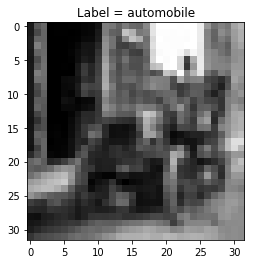

In [23]:
#Define cifar10's classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#Visualize one Entry
i = np.random.randint(X_train.shape[0])

fig,ax = plt.subplots()
fig.set_facecolor('w')

ax.imshow(X_train[i])
ax.set_title('Label = ' + str(classes[Y_train[i][0]]))
plt.show()

In [24]:
#Choose two classes for our classification model
class_a = 'bird' #Positive Class
class_b = 'airplane' #Negative Class

#Filter out the dataset to include only images in those classes
idx_a = classes.index(class_a)
idx_b = classes.index(class_b)
idx = np.logical_or(np.squeeze(Y_train) == idx_a, np.squeeze(Y_train) == idx_b)
X_train, Y_train = X_train[idx], Y_train[idx].astype(np.float64)
#Assign class_a = 1 and class_b=0
Y_train[np.where(Y_train == idx_a)] = 1.00
Y_train[np.where(Y_train == idx_b)] = 0.00

print('X_train has shape %s\nY_train has shape %s'%(X_train.shape, Y_train.shape))

idx = np.logical_or(np.squeeze(Y_test) == idx_a, np.squeeze(Y_test) == idx_b)
X_test, Y_test = X_test[idx], Y_test[idx].astype(np.float64)
#Assign class_a = 1 and class_b=0
Y_test[np.where(Y_test == idx_a)] = 1.00
Y_test[np.where(Y_test == idx_b)] = 0.00
print('X_test has shape %s\nY_test has shape %s'%(X_test.shape, Y_test.shape))

X_train has shape (10000, 32, 32, 3)
Y_train has shape (10000, 1)
X_test has shape (2000, 32, 32, 3)
Y_test has shape (2000, 1)


In [25]:
#Reshape X_train and X_test into (m, 32*32*3)
X_train_flat = X_train.reshape(X_train.shape[0], -1).T  
X_test_flat = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
X_train_norm = X_train_flat/255.
X_test_norm = X_test_flat/255.

print ("X_train's shape: " + str(X_train_norm.shape))
print ("X_test's shape: " + str(X_test_norm.shape))

X_train's shape: (3072, 10000)
X_test's shape: (3072, 2000)


### Defining our Model
The output is either 1 or 0 so the last layer dimension needs to be 1.
For the first dimension, that should be $32\times32\times3=3072$.
Let's start with a three layer model - $3072\times32\times1$ with layer activations ReLU-ReLU-Sigmoid

In [32]:
#Model Parameters
n_x = X_train_norm.shape[0]
n_y = 1
n_h = 7
model_shape = (n_x, n_h, n_y)

layer_activations = ['relu','relu','sigmoid']
optimizer = 'adam'

learning_rate = 0.001

parameters = train(X_train_norm,Y_train, model_shape, layer_activations, optimizer,
                   learning_rate=learning_rate, mini_batch_size=128)

Cost after epoch 0: 0.750187
Cost after epoch 100: 0.750183
Cost after epoch 200: 0.750171


KeyboardInterrupt: 

In [29]:
X_train_norm.shape

(3072, 10000)

In [31]:
Y_train.shape


(10000, 1)

In [ ]:
def test(Z):
    ret = np.copy(Z)
    ret[ret>0] = 1.00
    ret[ret <= 0] = 0.00
    dZ = np.multiply(dA, ret)